# Test Cross Power Spectrum

In this notebook, the cross power spectrum between the DR9 galaxy density and Galactic extinction map is investigated. 

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import healpy as hp
from healpy.rotator import Rotator
import fitsio as ft
import matplotlib.pyplot as plt
import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
from lssutils.lab import AnaFast
import lssutils.utils as ut
from lssutils.dataviz import setup_color

In [4]:
setup_color()

## NASA Lambda Map

https://lambda.gsfc.nasa.gov/product/foreground/fg_ebv_map.cfm

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


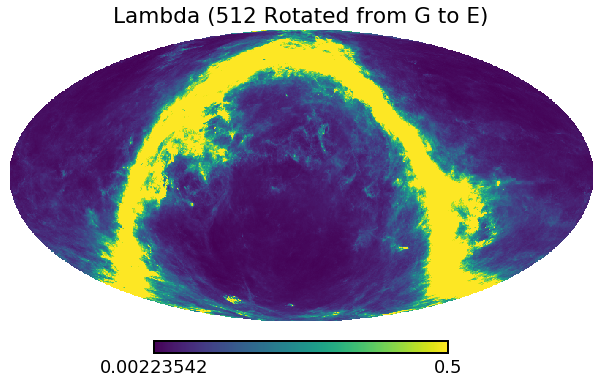

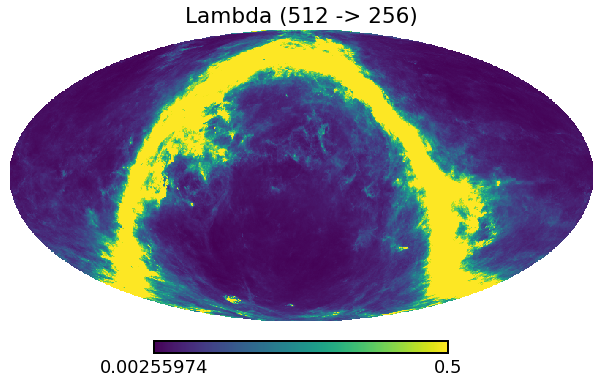

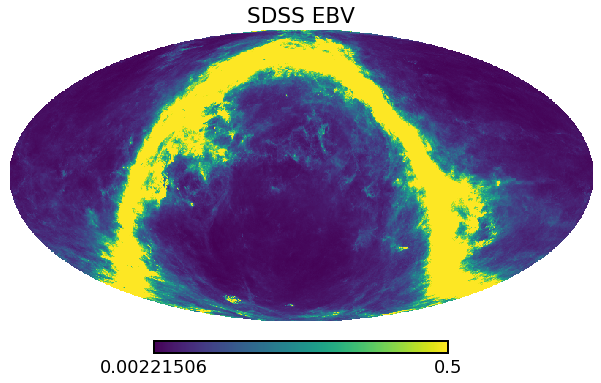

In [5]:
# read Lambda E[B-V] map
# nside=512, original in galactic
ebv_ = hp.read_map('/fs/ess/PHS0336/data/templates/lambda_sfd_ebv.fits', dtype=np.float32)
rt = Rotator(coord=['G', 'C'])
lambda_ebv = rt.rotate_map_pixel(ebv_)
lambda_ebv256 = hp.ud_grade(lambda_ebv, 256)


# dr9 data
data = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/nelg_features_bmzls_256.fits')
ngal = ut.make_hp(256, data['hpix'], data['label'])
frac = ut.make_hp(256, data['hpix'], data['fracgood'])
mask = ut.make_hp(256, data['hpix'], 1.0) > 0.5
random_ebv = ut.make_hp(256, data['hpix'], data['features'][:, 0])


# SDSS SFD map
# in NSIDE=256
sfd_old = hp.read_map('/fs/ess/PHS0336/data/templates/healSFD_256_fullsky.fits')

hp.mollview(lambda_ebv, max=0.5, title='Lambda (512 Rotated from G to E)')
hp.mollview(lambda_ebv256, max=0.5, title='Lambda (512 -> 256)')
hp.mollview(sfd_old, max=0.5, title='SDSS EBV')

In [23]:
from scipy.stats import pearsonr, spearmanr

0.9988076948772042 0.9985706977760417 
0.9993958452545167 0.9995704431530712 


Text(0, 0.5, 'Randoms EBV')

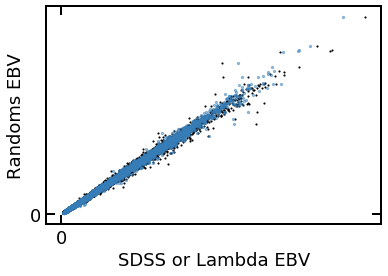

In [27]:
def plot_scatter(x, y, **kw):
    for cf in [pearsonr, spearmanr]:
        print(cf(x, y)[0], end=' ')
    plt.scatter(x, y, 5, **kw)
    print()

plot_scatter(sfd_old[mask], random_ebv[mask], marker='.', label='SDSS')
plot_scatter(lambda_ebv256[mask], random_ebv[mask], marker='o', label='Lambda', alpha=0.5)
plt.xscale('symlog', linthreshx=0.5)
plt.yscale('symlog', linthreshy=0.5)
plt.xlabel('SDSS or Lambda EBV')
plt.ylabel('Randoms EBV')

In [18]:
frac5 = hp.ud_grade(frac, 512)
mask5 = hp.ud_grade(mask, 512)
ngal5 = hp.ud_grade(ngal, 512, power=-2)
print(ngal[mask].sum(), ngal5[mask5].sum())

11288643.0 11288643.0


In [19]:
delta_lebv5 = ut.make_overdensity(lambda_ebv, frac5, mask5, is_sys=True)
delta_lebv = ut.make_overdensity(lambda_ebv256, frac, mask, is_sys=True)
delta_sebv = ut.make_overdensity(sfd_old, frac, mask, is_sys=True)
delta_rebv = ut.make_overdensity(random_ebv, frac, mask, is_sys=True)

delta_g = ut.make_overdensity(ngal, frac, mask)
delta_g5 = ut.make_overdensity(ngal5, frac5, mask5)

In [20]:
af = AnaFast()

In [21]:
cl_ebv = {}
cl_ebv['lambda[512]'] = af(delta_lebv5, frac5, mask5)
cl_ebv['lambda'] = af(delta_lebv, frac, mask)
cl_ebv['sdss'] = af(delta_sebv, frac, mask)
cl_ebv['randoms'] = af(delta_rebv, frac, mask)

Text(0, 0.5, 'C$_{\\ell}$/C$_{SDSS}$')

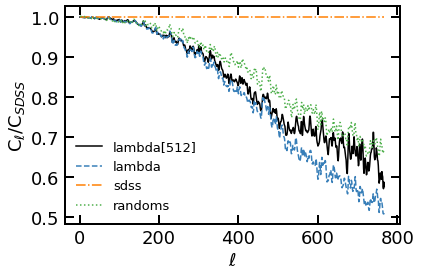

In [22]:
for n_i, cl_i in cl_ebv.items():
    plt.plot(cl_i['l'][1:768], cl_i['cl'][1:768]/cl_ebv['sdss']['cl'][1:768], label=f'{n_i}')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$/C$_{SDSS}$')
# plt.yscale('log')

In [28]:
def read_bin(clfile):
    lbins = np.arange(1, 1100, 11) # or 51
    cl_ = np.load(clfile, allow_pickle=True).item()
    lb, clb = ut.histogram_cell(cl_['cl_sg'][0]['cl'], bins=lbins)
    return (lb, clb)

In [29]:
lbins = np.arange(1, 1100, 11) # or 51
cl_lsg = af(delta_g, frac, mask, delta_lebv, frac, mask)
cl_lsg5 = af(delta_g5, frac5, mask5, delta_lebv5, frac5, mask5)

/users/PHS0336/medirz90/github/LSSutils/lssutils/utils.py:1057: RuntimeWarning: invalid value encountered in true_divide
  cell_bin = cell_weights_bin / weights_bin
/users/PHS0336/medirz90/github/LSSutils/lssutils/utils.py:1058: RuntimeWarning: invalid value encountered in true_divide
  ell_bin = ell_weights_bin / weights_bin


In [ ]:
cl_data = {}
cl_data['lambda ebv [256]'] = ut.histogram_cell(cl_lsg['cl'], bins=lbins)
cl_data['lambda ebv [512]'] = ut.histogram_cell(cl_lsg5['cl'], bins=lbins)
cl_data['randoms ebv [256]'] = read_bin('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_elg_bmzls_256_noweight.npy')
cl_data['randoms ebv [1024]'] = read_bin('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_elg_bmzls_1024_noweight.npy')

Text(0.5, 1.0, 'C$_{g,Lambda~or~Randoms~EBV}$')

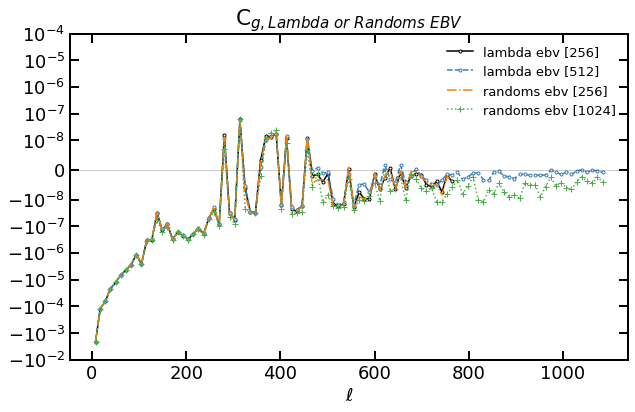

In [30]:
mk = ['.', '.', 'None', '+']
i = 0

plt.figure(figsize=(10, 6))
for n_i, cl_i in cl_data.items():
    plt.plot(*cl_i, label=n_i, marker=mk[i], mfc='w')
    i += 1
    
plt.yscale('symlog', linthreshy=1.0e-8)
plt.ylim(-1.0e-2, 1.0e-4)
plt.legend()
plt.axhline(0.0, lw=1, alpha=0.2)
plt.xlabel(r'$\ell$')
plt.title(r'C$_{g,Lambda~or~Randoms~EBV}$')
# plt.xscale('log')

In [31]:
cl_data['randoms ebv [256]'] = read_bin('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_elg_bmzls_256_nn.npy')
cl_data['randoms ebv [1024]'] = read_bin('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_elg_bmzls_1024_nn.npy')

/users/PHS0336/medirz90/github/LSSutils/lssutils/utils.py:1057: RuntimeWarning: invalid value encountered in true_divide
  cell_bin = cell_weights_bin / weights_bin
/users/PHS0336/medirz90/github/LSSutils/lssutils/utils.py:1058: RuntimeWarning: invalid value encountered in true_divide
  ell_bin = ell_weights_bin / weights_bin


Text(0.5, 1.0, 'C$_{g,Lambda~or~Randoms~EBV}$')

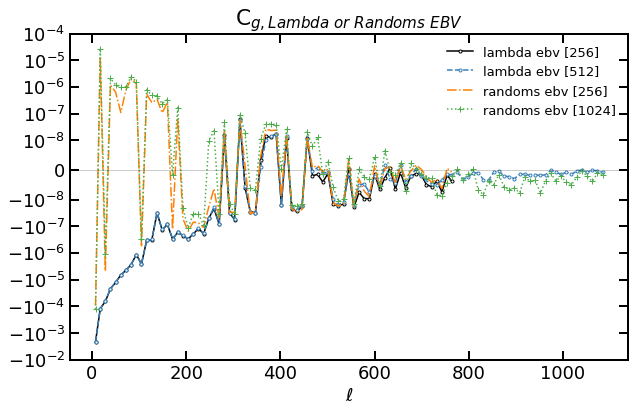

In [32]:
mk = ['.', '.', 'None', '+']
i = 0
# mitigated 
plt.figure(figsize=(10, 6))
for n_i, cl_i in cl_data.items():
    plt.plot(*cl_i, label=n_i, marker=mk[i], mfc='w')
    i += 1
    
plt.yscale('symlog', linthreshy=1.0e-8)
plt.ylim(-1.0e-2, 1.0e-4)
plt.legend()
plt.axhline(0.0, lw=1, alpha=0.2)
plt.xlabel(r'$\ell$')
plt.title(r'C$_{g,Lambda~or~Randoms~EBV}$')
# plt.xscale('log')